# Customer feedback satisfaction prediction

In [1]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression




# Load the dataset
data_path = os.path.abspath("./data/customer_feedback_satisfaction.csv")
data = pd.read_csv(data_path)

# Display basic info
data.info()

# Handle missing values
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

non_numeric_columns = data.select_dtypes(exclude=['number']).columns
for col in non_numeric_columns:
    if not data[col].isnull().all():
        data[col] = data[col].fillna(data[col].mode()[0])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38444 entries, 0 to 38443
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         38444 non-null  int64  
 1   Age                38444 non-null  int64  
 2   Gender             38444 non-null  object 
 3   Country            38444 non-null  object 
 4   Income             38444 non-null  int64  
 5   ProductQuality     38444 non-null  int64  
 6   ServiceQuality     38444 non-null  int64  
 7   PurchaseFrequency  38444 non-null  int64  
 8   FeedbackScore      38444 non-null  object 
 9   LoyaltyLevel       38444 non-null  object 
 10  SatisfactionScore  38444 non-null  float64
dtypes: float64(1), int64(6), object(4)
memory usage: 3.2+ MB


# Visualization 1: Distribution of Satisfaction Scores
### Why is this Feature Significant?
The distribution of satisfaction scores provides a foundational understanding of the target variable, highlighting its range, central tendency, and variability. This is crucial for determining the suitability of regression models and identifying potential biases or outliers in the data.

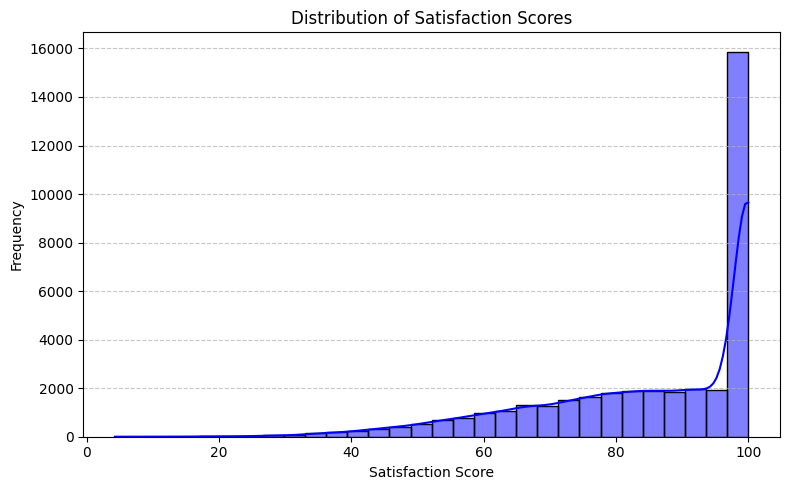

In [2]:
plt.figure(figsize=(8, 5))
sns.histplot(data['SatisfactionScore'], kde=True, bins=30, color='blue')
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Why is it Chosen as a Key Visualization?
A histogram with a KDE overlay provides a clear and intuitive representation of the distribution of satisfaction scores, combining both frequency counts and the underlying density. This approach highlights central tendencies, spread, and potential skewness, making it ideal for understanding the behavior of the target variable at a glance.

# Visualization 2: Satisfaction Score Distribution by Income Bin
### Why is this Feature Significant?
Income, as a measurable and continuous variable, offers a wide range of data points that enable the identification of nuanced trends and patterns in customer satisfaction. Its variability across different income groups allows for a deeper exploration of how financial capacity may influence satisfaction scores, providing insight into whether satisfaction is evenly distributed or tied to specific economic factors. This makes income a critical feature for uncovering relationships and dependencies that might not be apparent with categorical variables.

C:\Users\eliya\AppData\Local\Temp\ipykernel_42208\2351467023.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=pd.qcut(data['Income'], q=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High']),


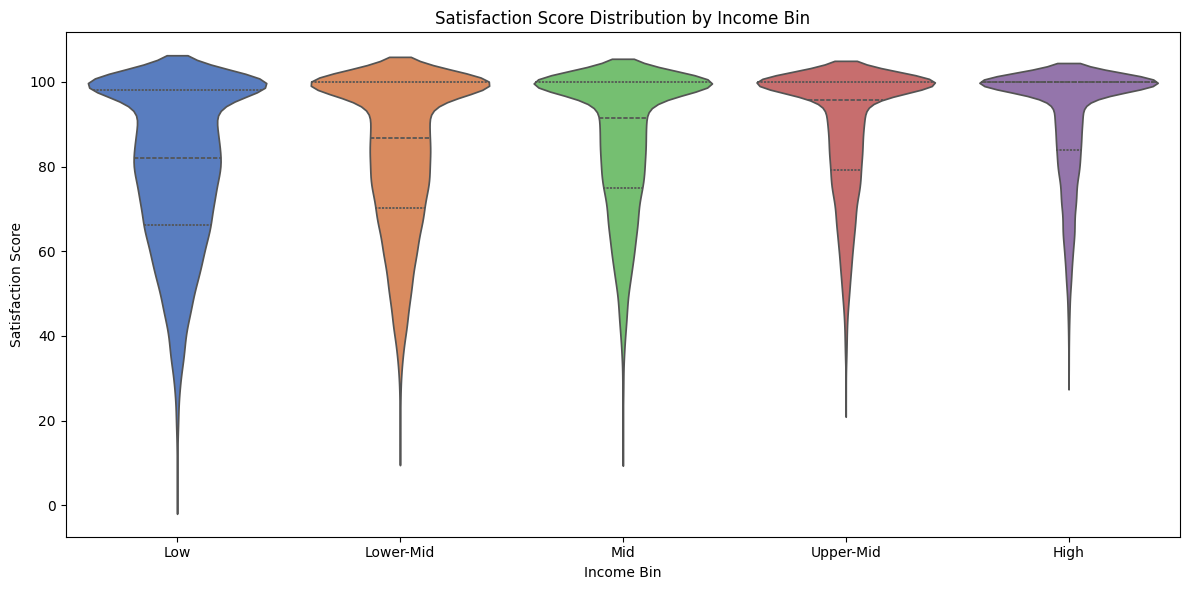

In [3]:
plt.figure(figsize=(12, 6))
sns.violinplot(x=pd.qcut(data['Income'], q=5, labels=['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High']),
               y='SatisfactionScore', data=data, palette='muted', inner='quartile', hue=None)
plt.title('Satisfaction Score Distribution by Income Bin')
plt.xlabel('Income Bin')
plt.ylabel('Satisfaction Score')
plt.tight_layout()
plt.show()


## Why is it Chosen as a Key Visualization?
The violin plot provides a comprehensive view of how satisfaction scores are distributed across different income bins by combining central tendencies (like medians), variability, and density. This visualization highlights systematic patterns, such as whether higher income correlates with greater satisfaction, while also identifying anomalies like outliers or uneven distributions. Its ability to compare differences between groups while retaining detailed individual distributions makes it an essential tool for understanding the nuanced relationship between income and satisfaction.

# Visualization 3: heatmap focused on SatisfactionScore
### Why is this Feature Significant?
Examining the correlation between SatisfactionScore and other features is essential for understanding which factors have the greatest influence on customer satisfaction. This analysis helps prioritize the most impactful features for predictive modeling and decision-making.

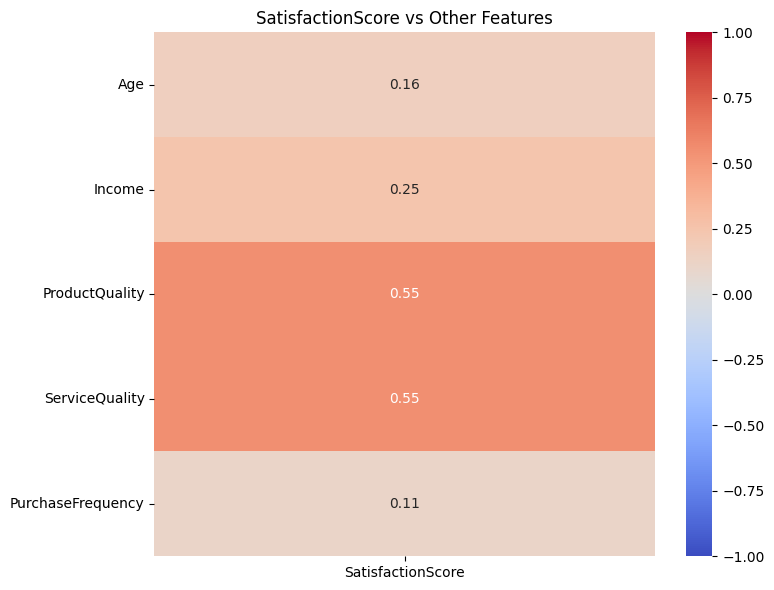

In [4]:
# Correlation heatmap focused on SatisfactionScore
plt.figure(figsize=(8, 6))

# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Remove 'CustomerID' and 'SatisfactionScore' from the columns to avoid unnecessary comparisons
numeric_data = numeric_data.drop(columns=['CustomerID', 'SatisfactionScore'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corrwith(data['SatisfactionScore']).to_frame(name='SatisfactionScore')

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, vmin=-1, vmax=1)
plt.title('SatisfactionScore vs Other Features')
plt.tight_layout()
plt.show()


## Why is it Chosen as a Key Visualization?
The heatmap provides a clear and intuitive overview of feature relationships, helping to identify the strongest predictors of SatisfactionScore while uncovering multicollinearity or redundant features. This makes it invaluable for streamlining feature selection and guiding data preprocessing for efficient modeling.

# Visualization 4: Satisfaction Score by Service Quality
### Why is this Feature Significant?
Service Quality is a direct measure of customer experience, making it a critical factor in understanding satisfaction. By analyzing its relationship with SatisfactionScore, we can determine whether improvements in service quality consistently lead to higher satisfaction levels, identify diminishing returns, and assess its importance as a predictor for satisfaction in future models.

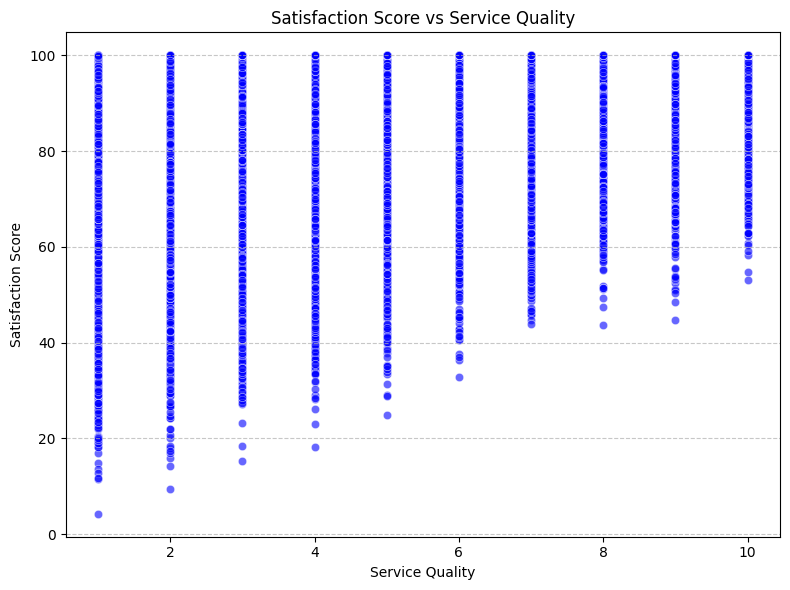

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ServiceQuality', y='SatisfactionScore', data=data, alpha=0.6, color='blue')
plt.title('Satisfaction Score vs Service Quality')
plt.xlabel('Service Quality')
plt.ylabel('Satisfaction Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Why is it Chosen as a Key Visualization?
The scatter plot is ideal for visualizing the direct relationship between Service Quality and Satisfaction Score, as it captures individual data points, trends, and variability in a straightforward manner. This method highlights whether the relationship is linear, non-linear, or subject to diminishing returns, enabling a clear understanding of how changes in service quality impact satisfaction. Such clarity is crucial for identifying thresholds where further improvements may no longer provide significant benefits, ensuring focused and efficient resource allocation.

# Visualization 5: Satisfaction Score by Product Quality
### Why is this Feature Significant?
Product quality is a cornerstone of the customer experience, directly influencing satisfaction levels. Analyzing its relationship with satisfaction scores helps determine whether enhancements in product quality result in meaningful improvements in satisfaction. This makes it a critical feature for understanding and prioritizing the factors that drive customer satisfaction.



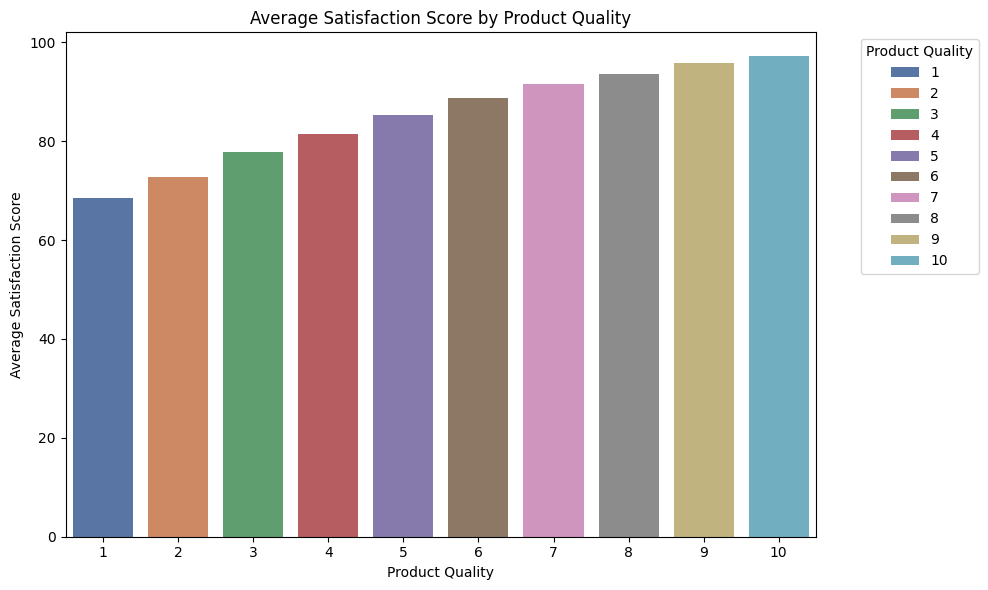

In [6]:
plt.figure(figsize=(10, 6))
avg_scores = data.groupby('ProductQuality')['SatisfactionScore'].mean().reset_index()
sns.barplot(x='ProductQuality', y='SatisfactionScore', data=avg_scores, hue='ProductQuality', palette='deep', dodge=False)
plt.title('Average Satisfaction Score by Product Quality')
plt.xlabel('Product Quality')
plt.ylabel('Average Satisfaction Score')
plt.legend(title='Product Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Why is it Chosen as a Key Visualization?
The bar plot provides a clear and intuitive comparison of average satisfaction scores across different levels of product quality, making it easy to identify trends and patterns. By aggregating the data, it highlights the overall impact of product quality on satisfaction while minimizing noise from individual variations, ensuring a focused and actionable representation of the relationship.

# Cleaning and Preprocessing


In [7]:
# Handle missing values
# For numerical columns, fill missing values with the mean
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# For categorical columns, fill missing values with the mode
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data[col].isnull().any():
        data[col] = data[col].fillna(data[col].mode()[0])

# Remove outliers using Z-Score for numerical columns
z_scores = data[numeric_columns].apply(zscore)
data = data[(z_scores < 3).all(axis=1)]

# Convert categorical variables to numerical using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

# Splitting data into features (X) and target (y)
X = data.drop(columns=['SatisfactionScore'])  # Drop the target column
y = data['SatisfactionScore']  # Define the target column

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Data cleaning and preprocessing complete. Ready for modeling!")

# Separate the dataset into features (X) and target (y)
X = data.drop(columns=['SatisfactionScore'])  # Drop the target variable
y = data['SatisfactionScore']  # Define the target variable

Data cleaning and preprocessing complete. Ready for modeling!


# Basic Model Pipeline 


In [8]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Model training complete!")

Model training complete!


# Evaluate the model

In [9]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
r2 = r2_score(y_test, predictions)
max_err = max(abs(y_test - predictions)) 
percentage_error = (mae / y_test.mean()) * 100 

# Print performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")
print(f"Max Error: {max_err:.3f}")
print(f"Percentage Error: {percentage_error:.2f}%")

Mean Absolute Error (MAE): 7.37
Mean Squared Error (MSE): 84.57
Root Mean Squared Error (RMSE): 9.20
R2 Score: 0.70
Max Error: 45.340
Percentage Error: 8.64%
